<a href="https://colab.research.google.com/github/nazanaza2970/BENTO-PACKAGING-ACTIVITY-RECOGNITION-CHALLENGE/blob/naza/Bento_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
import keras
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
# data = pd.DataFrame(columns = ['X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2', 'X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4',
#        'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8',
#        'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11', 'X12',
#        'Y12', 'Z12', 'X13', 'Y13', 'Z13', 'X14', 'Y14', 'Z14', 'X15', 'Y15',
#        'Z15', 'X16', 'Y16', 'Z16', 'X17', 'Y17', 'Z17', 'X18', 'Y18', 'Z18',
#        'X19', 'Y19', 'Z19', 'X20', 'Y20', 'Z20', 'X21', 'Y21', 'Z21', 'X22',
#        'Y22', 'Z22', 'X23', 'Y23', 'Z23', 'X24', 'Y24', 'Z24', 'X25', 'Y25',
#        'Z25', 'X26', 'Y26', 'Z26', 'X27', 'Y27', 'Z27', 'X28', 'Y28', 'Z28',
#        'X29', 'Y29', 'Z29', 'subject_id', 'activity'])

In [3]:
# # w_size = 10
# for file in tqdm(glob.glob("/content/drive/MyDrive/Competitions/2021/Bento 2021/Data/Train_data/*")):
#     temp = pd.read_csv(file)
#     data = data.append(temp)

In [4]:
# data.to_pickle("/content/drive/MyDrive/Competitions/2021/Bento 2021/Data/cobined_data.pkl", compression = "xz")
# data

In [5]:
data = pd.read_pickle("/content/drive/MyDrive/Competitions/2021/Bento 2021/Data/cobined_data.pkl", compression = "xz")

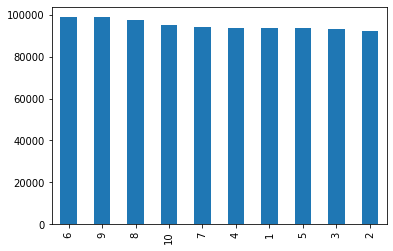

In [6]:
data['activity'].value_counts().plot.bar()

In [7]:
data.isnull().sum().sum()

846447

In [8]:
def segmentation(x_data,overlap_rate,time_window):
    
    # make a list for segment window and its label
    seg_data = []
    y_segmented_list = []

    #convert overlap rate to step for sliding window
    overlap = int((1 - overlap_rate)*time_window)
    
    #segment and keep the labels
    for i in range(0,x_data.shape[0],overlap):
        seg_data.append(x_data[i:i+time_window])
        y_segmented_list.append(x_data['activity'][i])
        
    return seg_data,y_segmented_list

In [9]:
def entropy(a):
        a = (a-min(a))/(max(a)-min(a))
        return stats.entropy(a)

In [61]:
def get_features(x_data):
    #Set features list
    features = []
    #Set columns name list
    DFclist=list(x_data.columns)

    #Calculate features (STD, Average, Max, Min) for each data columns X Y Z 
    for k in DFclist:
        # std
        features.append(x_data[k].std(ddof=0))
        # avg
        features.append(np.average(x_data[k]))
        # max
        features.append(np.max(x_data[k]))
        # min
        features.append(np.min(x_data[k]))
        #median
        features.append(np.median(x_data[k]))                                
        #mode
        # features.append(stats.mode(x_data[k]))                                  #produces single value
        #variance
        features.append(np.var(x_data[k]))
        #skewness
        features.append(stats.skew(x_data[k]))
        #kutosis
        features.append(stats.kurtosis(x_data[k]))
        #mad
        # features.append(x_data[k].apply(lambda x: pd.Series(x).mad()))           #too slow
        #energy
        # features.append(x_data[k].apply(lambda x: sum(x**2)/len(x)))             #throws error
        #iqr
        # features.append(x_data[k].apply(stats.iqr))
        #entropy
        # features.append(x_data[k].apply(entropy))                                #throws error
    return features

In [55]:
from sklearn.ensemble import RandomForestClassifier         
model_ml = RandomForestClassifier(n_estimators=500,n_jobs=-1)

In [66]:
#Segmentation with overlaprate=0 & window=100
df1_itpl=data.reset_index(drop = True).interpolate()
#replace missing values with 0
df1_itpl=df1_itpl.fillna(0) 
[seg, seg_label]=segmentation(df1_itpl,0.5,100)
      

In [67]:
#set list
features_list=[]
label_list=[]
for j in tqdm(range(0,len(seg))):
    #extract only xyz columns
            frame1=seg[j].drop(columns=['subject_id','activity'])
            

            #Get features and label for each elements
            features_list.append(get_features(frame1))
            label_list.append(seg_label[j])

100%|██████████| 19013/19013 [29:23<00:00, 10.78it/s]


In [68]:
X_train, X_test, y_train, y_test = train_test_split(features_list, label_list, test_size=0.3, random_state=69)

In [69]:
model_ml.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [74]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_ml, features_list, label_list, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [75]:
n_scores

array([0.95741325, 0.96109359, 0.95899054, 0.959495  , 0.95633877,
       0.96265124, 0.9621252 , 0.95633877, 0.96580747, 0.96107312,
       0.9637224 , 0.9553102 , 0.96161935, 0.96685955, 0.95791689,
       0.95213046, 0.959495  , 0.95739085, 0.95791689, 0.95581273,
       0.96056782, 0.96319664, 0.96161935, 0.95528669, 0.96054708,
       0.95633877, 0.95213046, 0.96738559, 0.959495  , 0.95528669])

              precision    recall  f1-score   support

           1       0.95      0.97      0.96       569
           2       0.97      0.92      0.94       564
           3       0.95      0.95      0.95       559
           4       0.92      0.90      0.91       574
           5       0.93      0.88      0.91       549
           6       0.97      0.99      0.98       589
           7       0.96      0.98      0.97       584
           8       0.98      0.95      0.97       564
           9       0.93      0.97      0.95       588
          10       0.93      0.97      0.95       564

    accuracy                           0.95      5704
   macro avg       0.95      0.95      0.95      5704
weighted avg       0.95      0.95      0.95      5704



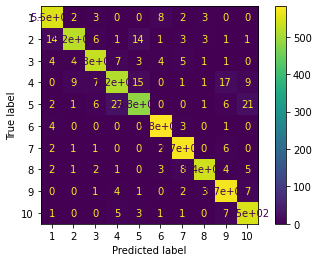

In [70]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_predict = model_ml.predict(X_test)
print(classification_report(y_test,y_predict))
#confusion_matrix(y_test, y_predict)
plot_confusion_matrix(model_ml, X_test, y_test)
plt.show()

In [76]:
pickle.dump(model_ml,open("/content/drive/MyDrive/Competitions/2021/Bento 2021/Models/RFC3/rfc3.sav","wb"))

In [18]:
 # X_train = np.nan_to_num(np.array(X_train))
# X_train[X_train>1E308]=0
# X_train = list(X_train)